<h1 align=center>Fall 2017: <a href="http://cs.mcgill.ca/~jpineau/comp551/">Applied Machine Learning</a></h1>
<h2 align=center>Tutorial 2 : Libraries and Text Classification</h2>
<h3 align=center>Matthew Smith, Koustuv Sinha</h3>

In [1]:
from __future__ import print_function

# Advanced Numpy: Broadcasting
(Written by Pierre-Luc Bacon)

Thinking about for-loops or Matlab's [repmat](http://www.mathworks.com/help/matlab/ref/repmat.html) ? The chances are that you can avoid all of that and leverage the powerful concept of [broadcasting](http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) in Numpy. 

Broadcasting allows you to essentially mimic the process of copying or repeating a given array object to match the dimensions of a larger array. Some magics is implemented under the hood (within [Blas](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms)) which makes broadcasting operations both cpu and memory efficient.

<img src="http://www.astroml.org/_images/fig_broadcast_visual_1.png"/>

(Figure taken from [AstroML](http://www.astroml.org/book_figures/appendix/fig_broadcast_visual.html))

## General Rules of Broadcasting

When operating on two arrays, numpy compares their shapes element-wise, starting with the _last_ dimension. Two dimensions are compatible if:

1) they are equal, or
2) one of them is 1

If these conditions are not met, an error will occur. Note again that the _arrays do not have to have the same dimensions_.

For example, broadcasting will work in these cases:
```
A (3d array): 256 x 256 x 3
b   (scalar):             3

A (4d array): 10 x 12 x 13 x 14
B (3d array):      12 x  1 x 14
```

But not these cases:
```
A (3-d array): 256 x 256 x 3
b (2-d array):         3 x 1

A (4d array): 10 x 12 x 13 x 14
B (3d array):      12 x 14 x  1
```

Here is an example of the simplist form of broadcasting: vector-scalar addition

In [2]:
import numpy as np

a = np.arange(4) + 0.5
b = np.arange(4) + np.array([0.5, 0.5, 0.5, 0.5])
(a == b).all()

True

See [here](http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) for full documentation.

# Python for Text Classification

## Loading Data
<a id="datacell"></a>
For the rest of the notebook, please download and extract data from <a href="http://cs.mcgill.ca/~msmith108/data.zip">here</a> in the same directory as the notebook file.

You can use beautiful soup to parse the XML data that you have gathered. You probably have already used it.

If not, you can use:

```
pip install beautifulsoup4
```

In [3]:
from bs4 import BeautifulSoup
with open("./data/samplegroup_eng.xml", mode="r") as f:
    raw_data = f.read()
print(raw_data)

<dialog>
    <s><utt uid="1">Hey, how are you?</utt><utt uid="2">I’m fine thank you!</utt><utt uid="1">Nice!</utt></s>
    <s><utt uid="1">Who’s around for lunch?</utt><utt uid="2">Me!</utt><utt uid="3">Me too!</utt></s>
</dialog>



In [4]:
soup = BeautifulSoup(raw_data, 'html.parser')
utterances = soup.find_all('utt')
dat = {"x": [], "y": []}
for utt in utterances:
    dat["x"].append(utt.get_text())
    dat["y"].append(utt["uid"])

import json
print(json.dumps(dat, indent=2))

{
  "x": [
    "Hey, how are you?",
    "I\u2019m fine thank you!",
    "Nice!",
    "Who\u2019s around for lunch?",
    "Me!",
    "Me too!"
  ],
  "y": [
    "1",
    "2",
    "1",
    "1",
    "2",
    "3"
  ]
}


Since this dataset is too small, we will use the larger one downloaded [earlier](#datacell), but everything else will be mostly the same!

We will be using IMDB movie review dataset from (Maas et. al. 2011). Reviews are either classified as positive or as negative.

In [5]:
import os

dat = {"x": [], "y": []}

negative_review_path = "./data/aclImdb/dat/neg/"
positive_review_path = "./data/aclImdb/dat/pos/"

for f in os.listdir(negative_review_path):
    with open(negative_review_path + f, mode="r") as review:
        dat["x"].append(review.read())
        dat["y"].append(0)
        
for f in os.listdir(positive_review_path):
    with open(positive_review_path + f, mode="r") as review:
        dat["x"].append(review.read())
        dat["y"].append(1)

dat["y"] = np.array(dat["y"])

## Learning From Data: an Introduction to Scikit-learn
---
<a href="http://scikit-learn.org/stable/">scikit-learn</a> is a python library which implements common learning algorithms, evaluation methods, and data processing tools with a unified interface. 


### Installation
If you installed python using <a href="https://www.anaconda.com/">Anaconda</a>, then you already have scikit learn!

Otherwise you can use:
```
pip install -U scikit-learn
```

Or if you installed python using conda:
```
conda install scikit-learn
```

## IMPORTANT! Splitting Data Into Testing and Training Sets

Right away, before doing anything else, it is often a good idea to set aside an appropriately sized training set, so that there is no chance that we overfit to this particular batch of data. Pass the `random_state` parameter here to make sure that the split is always the same! Pass shuffle=True to ensure there isnt correlation between test set and training set examples.

In [6]:
from sklearn import model_selection
split = model_selection.train_test_split(dat["x"], dat["y"], test_size=0.2, shuffle=True, random_state=551)
train_x, test_x, train_y, test_y = split

## Preprocessing Data
In machine learning, one of the most important questions lies in the representation of the data. How can we transform our text data into data that our models can learn from?

#### Idea: Represent documents as a "Bag-of-Words"
Assume that the order of words doesn't matter. We can represent each document as a vector of dimension $W$, where $W$ is the number of words in the entire dataset. At each index, we can fill the vector with the number of times that word appears in that document. Alternatively we can use term-frequency inverse-document-frequency (TF-IDF), representation, with component $i$ given by:
$$
\phi(d)_i = t_{di} \cdot \log\left(\frac{N}{f_i}\right)
$$
Where $N$ is the size of the data set, $t_{di}$ is the number of times word $i$ is found in document $d$, and $f_i$ is the number of documents word $i$ appears in.

`sklearn` has good implementations of these that are easy to use

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()
vec.fit(train_x)

train_x = vec.transform(train_x)
test_x = vec.transform(test_x)

print("Training Data Size:", train_x.shape, "Testing Data Size:", test_x.shape)

Training Data Size: (20000, 68539) Testing Data Size: (5000, 68539)


### Training A Model
scikit-learn makes it easy to build, test, and evaluate many different models, making it easier to figure out what the
right model is for the data that you are working with. The `sklearn` workflow is as follows:

#### 1) Select a model, and import it from the relevant module
Choose the appropriate model for your data from the list <a href="http://scikit-learn.org/stable/modules/classes.html">here</a>

When doing this, consider the unique characteristics of your data, and how it corresponds to the models that you have seen in class (i.e. what assumptions does your model make about your data, and how valid are those assumptions).

You will likely try many, since it is easy to do, and sometimes you cannot be certain about how your data will interact with any given model without trying.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB

#### 2) Initialize the class, passing parameters to configure the model
We can choose our hyperparameters carefully, based on prior intuition and understanding of the model and the data,
but this often requires tuning by grid search or random search.

Lets investigate the Logistic Regression classifier first.

In [20]:
lr_classifier = LogisticRegression(penalty='l2', C=1)

#### 3) Fit the model to the data
While implementing this step is normally one of the hard parts of machine learning, with sklearn, you simply pass the data to the model through the `fit()` method, and the model parameters are learned!

In [10]:
print("Training the model...", end="")
lr_classifier.fit(train_x, train_y)
print("Done")

Training the model...Done


We can inspect the learned parameters of the model after it has been fit

In [11]:
print(lr_classifier.coef_)

[[-3.32183573 -2.23918055 -0.29774178 ...,  0.01230198 -0.96716752
  -0.37671159]]


#### 4) Evaluate the model on test and validation data
`sklearn` provides useful functions to evaluate our models, and to perform cross-validation.

We can use our model to make predictions of the data!

In [12]:
train_y_pred = lr_classifier.predict(train_x)
print("Training Set Accuracy:", (train_y == train_y_pred).mean())

Training Set Accuracy: 1.0


If we want to optimize the hyperparameters of our model, we should do cross validation. Let's experiment with the strength of regularization in a logistic regression model. The  `sklearn.linear_model.LogisticRegression` class accepts a parameter `C`, which represents the inverse of regularization strength.

In [13]:
from sklearn import metrics


# First, set up K-fold cross validation
model_performance = []

# We have a list of candidate regularization strengths
cs = [1e-3,1e-2, 1e-1, 1, 1e1, 1e2, 1e3]

for c in cs:
    
    # sklearn.model_selection.KFold().split(dat) returns an iterater over indicies for k-fold validation
    folds = model_selection.KFold(5, shuffle=True, random_state=598).split(train_y)
    
    # store training and validation accuracies for each fold
    train_acc = []
    val_acc = []
    
    for train, val in folds:
        
        # Train the model
        clf = LogisticRegression(penalty='l2', C=c, max_iter=1000)
        clf.fit(train_x[train], train_y[train])
        
        # Predict
        ypred_val = clf.predict(train_x[val])
        ypred_train = clf.predict(train_x[train])
        
        # Save accuracy
        val_acc.append((train_y[val] == ypred_val).mean())
        train_acc.append((train_y[train] == ypred_train).mean())
    
    # Save accuracies for plotting
    avg_val_acc = np.mean(val_acc)
    avg_train_acc = np.mean(train_acc)
    
    # Save standard deviation for confidence bounds
    std_val_acc = np.std(val_acc)
    std_train_acc = np.std(train_acc)
    
    print(f"C: {c} |  Training Accuracy: {avg_train_acc}  | Validation Accuracy: {avg_val_acc}")
    model_performance.append((avg_val_acc, avg_train_acc, std_val_acc, np.std(train_acc)))
    


C: 0.001 |  Training Accuracy: 0.76345  | Validation Accuracy: 0.74865
C: 0.01 |  Training Accuracy: 0.7944500000000001  | Validation Accuracy: 0.78415
C: 0.1 |  Training Accuracy: 0.8617250000000001  | Validation Accuracy: 0.8417499999999999
C: 1 |  Training Accuracy: 0.9337500000000001  | Validation Accuracy: 0.88355
C: 10.0 |  Training Accuracy: 0.9920000000000002  | Validation Accuracy: 0.89155
C: 100.0 |  Training Accuracy: 1.0  | Validation Accuracy: 0.8862
C: 1000.0 |  Training Accuracy: 1.0  | Validation Accuracy: 0.8811


[Seaborn](https://seaborn.pydata.org/index.html) is a cool package that makes your plots look way better. Simply importing it changes the defaults of matplotlib, making most plots look way nicer.

In [14]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

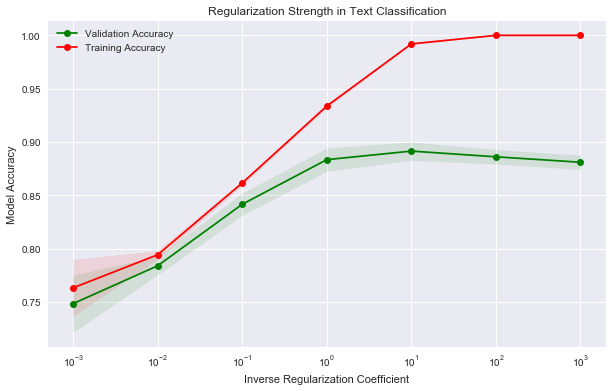

In [40]:
plt.figure(figsize=(10,6))
plt.plot(cs,[p[0] for p in model_performance],'o-', color="g")
plt.plot(cs,[p[1] for p in model_performance],'o-', color="r")
plt.fill_between(cs, [p[0] + p[2] for p in model_performance],
                     [p[0] - p[2] for p in model_performance], alpha=0.1, color="g")
plt.fill_between(cs, [p[1] + p[3] for p in model_performance],
                     [p[1] - p[3] for p in model_performance], alpha=0.1, color="r")
plt.title("Regularization Strength in Text Classification")
plt.xscale('log')
plt.xlabel("Inverse Regularization Coefficient")
plt.ylabel("Model Accuracy")
plt.legend(["Validation Accuracy", "Training Accuracy"])
plt.show()

scikit learn also allows us to do grid search automatically, and in parallel. This allows us to optimize our models over combinations of hyperparameters. We will demonstrate this, and some more evaluation tools on the famous "iris" toy dataset

In [16]:
from sklearn import datasets
from sklearn.svm import SVC

dat = datasets.load_iris()
split = model_selection.train_test_split(dat.data[:,:2], dat.target, test_size=0.2, shuffle=True, random_state=551)
train_x, test_x, train_y, test_y = split

We set up the candidate parameters for our grid search beforehand. When we call the `fit` method, all possible combinations of these parameters will be tried. When we set n_jobs to -1, sklearn will automatically parallelize our grid search, using as many cores as are available, and fitting all of the models at once, making grid search must faster.

In [17]:
search_parameters = [
    {
        'kernel': ['rbf'],
        'gamma': [1e-3, 1e-4],
        'C': [1, 10, 100, 1000]
    },
    {
        'kernel': ['linear'],
         'C': [1, 10, 100, 1000]
    }
]

svm = model_selection.GridSearchCV(SVC(), search_parameters, cv=3, n_jobs=-1)
svm.fit(train_x, train_y)
print("The Best Estimator Was:")
print(svm.best_estimator_)
print(f"With Accuracy: {svm.best_score_ }")
print("Grid scores on train set:")
for params, mean_score, scores in zip(svm.cv_results_["params"], svm.cv_results_["mean_test_score"],  svm.cv_results_["std_test_score"]):
    print("%0.3f (+/-%0.03f) for %r"%(mean_score, scores.std() / 2, params))

The Best Estimator Was:
SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
With Accuracy: 0.8166666666666667
Grid scores on train set:
0.358 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.358 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.583 (+/-0.000) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.358 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.808 (+/-0.000) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.583 (+/-0.000) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.817 (+/-0.000) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.808 (+/-0.000) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.808 (+/-0.000) for {'C': 1, 'kernel': 'linear'}
0.817 (+/-0.000) for {'C': 10, 'kernel': 'linear'}
0.817 (+/-0.000) for {'C': 100, 'kernel': 'linear'}
0.817 (+/-0.000) f

The grid search model that we just trained will automatically use the best model in future calls to `predict`

In [18]:
test_y_hat = svm.predict(test_x)
print(f"Testing Accuracy: {np.mean(test_y == test_y_hat)}")

Testing Accuracy: 0.7666666666666667


Another useful plot that can be easily generated by scikit-learn is the confusion matrix, a heatmap between the ground-truth data labels and the labels that were chosen by the classifier. An ideal classifier has non-zero entries only on the diagonal. Here we can see that class 0 was classified perfectly, but there was less distinction between classes 1 and 2. 

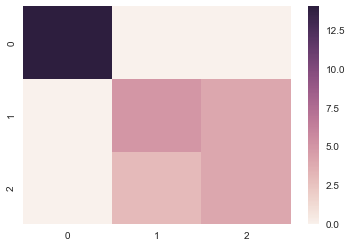

In [38]:
cm = metrics.confusion_matrix(test_y, test_y_hat)
seaborn.heatmap(cm)
plt.show()